# Use Core ML to predict Boston house prices with `ibm-watson-machine-learning`

This notebook demonstrates how to perform regression analysis using scikit-learn and the watson-machine-learning-client package.

Some familiarity with Python is helpful. This notebook is compatible with Python 3.7.

You will use the sample data set, **sklearn.datasets.load_boston** which is available in scikit-learn, to predict house prices.

## Learning goals

In this notebook, you will learn how to:

-  Load a sample data set from ``scikit-learn``
-  Explore data
-  Prepare data for training and evaluation
-  Create a scikit-learn pipeline
-  Train and evaluate a model
-  Store a model in the Watson Machine Learning (WML) repository
-  Deploy a model as Core ML


## Contents

1.	[Set up the environment](#setup)
2.	[Load and explore data](#load)
3.	[Build a scikit-learn linear regression model](#model)
4.	[Set up the WML instance and save the model in the WML repository](#persistence)
5.	[Deploy the model via Core ML](#scoring)
6.  [Clean up](#cleanup)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [2]:
wml_credentials = {
    "username": username,
    "apikey": api_key,
    "url": url,
    "instance_id": 'openshift',
    "version": '4.0'
}

Alternatively you can use `username` and `password` to authenticate WML services.

```
wml_credentials = {
    "username": ***,
    "password": ***,
    "url": ***,
    "instance_id": 'openshift',
    "version": '4.0'
}

```

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install -U ibm-watson-machine-learning

In [ ]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd4.0/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [ ]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

<a id="load"></a>
## 2. Load and explore data

The sample data set contains boston house prices. The data set can be found <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/housing/" target="_blank" rel="noopener no referrer">here</a>.

In this section, you will learn how to:
- [2.1 Explore Data](#dataset)  
- [2.2 Check the correlations between predictors and the target](#corr)

### 2.1 Explore data<a id="dataset"></a>

In this subsection, you will perform exploratory data analysis of the boston house prices data set.

In [ ]:
!pip install --upgrade scikit-learn==0.23.1 seaborn

In [5]:
import sklearn
from sklearn import datasets
import pandas as pd

boston_data = datasets.load_boston()

Let's check the names of the predictors.

In [6]:
print(boston_data.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


**Tip:** Run `print(boston_data.DESCR)` to view a detailed description of the data set.

In [7]:
print(boston_data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Create a pandas DataFrame and display some descriptive statistics.

In [8]:
boston_pd = pd.DataFrame(boston_data.data)
boston_pd.columns = boston_data.feature_names
boston_pd['PRICE'] = boston_data.target

The describe method generates summary statistics of numerical predictors.

In [9]:
boston_pd.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 2.2 Check the correlations between predictors and the target<a id="corr"></a>

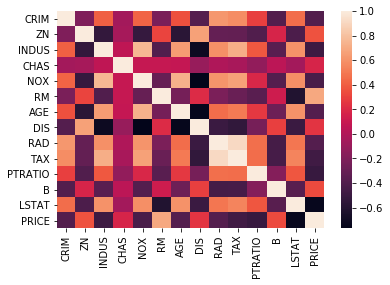

In [10]:
import seaborn as sns
%matplotlib inline

corr_coeffs = boston_pd.corr()
sns.heatmap(corr_coeffs, xticklabels=corr_coeffs.columns, yticklabels=corr_coeffs.columns);

<a id="model"></a>
## 3. Build a scikit-learn linear regression model

In this section, you will learn how to:
- [3.1 Split data](#prep)
- [3.2 Create a scikit-learn pipeline](#pipe)
- [3.3 Train the model](#train)

### 3.1 Split data<a id="prep"></a>

In this subsection, you will split the data set into: 
- Train data set
- Test data set

In [12]:
from sklearn.model_selection import train_test_split

X = boston_pd.drop('PRICE', axis = 1)
y = boston_pd['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 5)

print('Number of training records: ' + str(X_train.shape[0]))
print('Number of test records: ' + str(X_test.shape[0]))

Number of training records: 339
Number of test records: 167


Your data has been successfully split into two data sets: 

-  The train data set, which is the largest group, is used for training.
-  The test data set will be used for model evaluation and is used to test the model.

### 3.2 Create a scikit-learn pipeline<a id="pipe"></a>

In this subsection, you will create a scikit-learn pipeline.

First, import the scikit-learn machine learning packages that are needed in the subsequent steps.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Standardize the features by removing the mean and by scaling to unit variance.

In [14]:
scaler = preprocessing.StandardScaler()

Next, define the regressor you want to use. This notebook uses the Linear Regression model.

In [15]:
lr = LinearRegression()

Build the pipeline. A pipeline consists of a transformer (Standard Scaler) and an estimator (Linear Regression model).

In [16]:
pipeline = Pipeline([('scaler', scaler), ('lr', lr)])

### 3.3 Train the model<a id="train"></a>

Now, you can use the **pipeline** and **train data** you defined previously to train your SVM model.

In [17]:
model = pipeline.fit(X_train, y_train)

Check the model quality.

In [18]:
y_pred = model.predict(X_test)
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

print('MSE: ' + str(mse))

MSE: 28.530458765974625


Plot the scatter plot of prices vs. predicted prices.

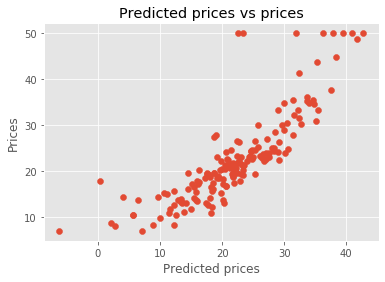

In [19]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.title('Predicted prices vs prices')
plt.ylabel('Prices')
plt.xlabel('Predicted prices')
plot = plt.scatter(y_pred, y_test)

**Note:** You can tune your model to achieve better accuracy. To keep this example simple, the tuning section is omitted.

<a id="persistence"></a>
## 4. Save the model in the WML repository

In this section, you will learn how to use the common Python client to manage your model in the WML repository.

In [20]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

metadata = {
            client.repository.ModelMetaNames.NAME: 'Boston house price',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=model,
    meta_props=metadata,
    training_data=X_train, training_target=y_train)


In [21]:
model_uid = client.repository.get_model_uid(published_model)

#### Get information about all of the models in the WML repository.

In [ ]:
models_details = client.repository.list_models()

<a id="scoring"></a>
## 5. Deploy the model via Core ML

In this section, you will learn how to use the WML client to create a **virtual** deployment via the `Core ML`. You will also learn how to use `download_url` to download a Core ML model for your <a href="https://developer.apple.com/xcode/" target="_blank" rel="noopener no referrer">Xcode</a> project.

- [5.1 Create a virtual deployment for the model](#create)
- [5.2 Download the Core ML file from the deployment](#getdeploy)
- [5.3 Test the CoreML model](#testcoreML)

### 5.1 Create a virtual deployment for the model<a id="create"></a>

In [22]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Virtual deployment of Boston model",
    client.deployments.ConfigurationMetaNames.VIRTUAL: {"export_format": "coreml"}
}

created_deployment = client.deployments.create(model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '9b319604-4b55-4a86-8728-51572eeeb761' started

#######################################################################################


initializing.........................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='29ebee31-849b-4ef1-b201-259dbddeb158'
------------------------------------------------------------------------------------------------




Now, you can define and print the download endpoint. You can use this endpoint to download the Core ML model.

### 5.2 Download the `Core ML` file from the deployment<a id="getdeploy"></a>

In [ ]:
client.deployments.list()

#### Download the virtual deployment content: Core ML model.

In [23]:
deployment_uid = client.deployments.get_uid(created_deployment)

deployment_content = client.deployments.download(deployment_uid)



----------------------------------------------------------
Successfully downloaded deployment file: mlartifact.tar.gz
----------------------------------------------------------




Use the code in the cell below to create the download link.

In [24]:
from ibm_watson_machine_learning.utils import create_download_link

create_download_link(deployment_content)

**Note:** You can use <a href="https://developer.apple.com/xcode/" target="_blank" rel="noopener no referrer">Xcode</a> to preview the model's metadata (after unzipping). 

### 5.3 Test the `Core ML` model<a id="testcoreML"></a>

Use the following steps to run a test against the downloaded Core ML model.

In [ ]:
!pip install --upgrade coremltools

Use the ``coremltools`` to load the model and check some basic metadata.

First, extract the model.

In [25]:
from ibm_watson_machine_learning.utils import extract_mlmodel_from_archive

extracted_model_path = extract_mlmodel_from_archive('mlartifact.tar.gz', model_uid)

Load the model and check the description.

In [26]:
import coremltools

loaded_model = coremltools.models.MLModel(extracted_model_path)
print(loaded_model.get_spec())

specificationVersion: 1
description {
  input {
    name: "input"
    type {
      multiArrayType {
        shape: 13
        dataType: DOUBLE
      }
    }
  }
  output {
    name: "prediction"
    type {
      doubleType {
      }
    }
  }
  predictedFeatureName: "prediction"
  metadata {
    shortDescription: "\'description\'"
    userDefined {
      key: "coremltoolsVersion"
      value: "3.4"
    }
  }
}
pipelineRegressor {
  pipeline {
    models {
      specificationVersion: 1
      description {
        input {
          name: "input"
          type {
            multiArrayType {
              shape: 13
              dataType: DOUBLE
            }
          }
        }
        output {
          name: "__feature_vector__"
          type {
            multiArrayType {
              shape: 13
              dataType: DOUBLE
            }
          }
        }
        metadata {
          userDefined {
            key: "coremltoolsVersion"
            value: "3.4"
          }
    

The model looks good and can be used on your iPhone now.

<a id="cleanup"></a>
## 6. Clean up 

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd4.0/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 7. Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use scikit-learn to create a Core ML model.

If you are interested in sample swift application (for iOS), please visit <a href="https://github.com/IBM/watson-machine-learning-samples/tree/master/cloud/applications/go-digits" target="_blank" rel="noopener no referrer">here</a>. 

Check out our <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Lukasz Cmielowski**, Ph.D., is a Lead Data Scientist at IBM developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.  
**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who strives to make data science easy for everyone through Watson Studio.

Copyright © 2020, 2021 IBM. This notebook and its source code are released under the terms of the MIT License.